In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import warnings
pd.options.display.max_columns = 100

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Исследование данных

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [3]:
data.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,10000,NaN,NaN,NaN,8383.41,4859.02,0,4169.5,8394.5,12592.5,16798
DistrictId,10000,NaN,NaN,NaN,50.4008,43.5876,0,20,36,75,209
Rooms,10000,NaN,NaN,NaN,1.8905,0.839512,0,1,2,2,19
Square,10000,NaN,NaN,NaN,56.3158,21.0587,1.13686,41.7749,52.5133,65.9006,641.065
LifeSquare,7887,NaN,NaN,NaN,37.1996,86.2412,0.370619,22.7698,32.7813,45.1288,7480.59
KitchenSquare,10000,NaN,NaN,NaN,6.2733,28.5609,0,1,6,9,2014
Floor,10000,NaN,NaN,NaN,8.5267,5.24115,1,4,7,12,42
HouseFloor,10000,NaN,NaN,NaN,12.6094,6.77597,0,9,13,17,117
HouseYear,10000,NaN,NaN,NaN,3990.17,200500,1910,1974,1977,2001,2.0052e+07
Ecology_1,10000,NaN,NaN,NaN,0.118858,0.119025,0,0.0176471,0.0754237,0.195781,0.521867


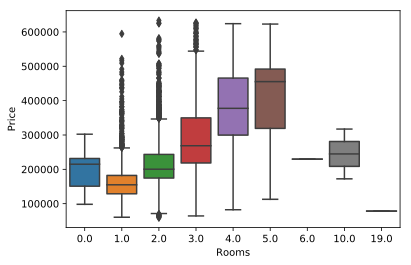

In [4]:
sns.boxplot(data['Rooms'], data['Price'])

#### Предварительные исследования данных показали, что данные требуют очистки от выбросов.
#### Данные практически полные. Показатель жилой площади (78% данных) подлежит дорасчету.
#### Показатель Healthcare_1 (52% данных) использовать не будем, как не ключевой.

### Подготовка данных

In [5]:
#Разбивка датасета на тестовый и валидационный
train, valid = train_test_split(data, test_size=0.3, random_state=42)

In [6]:
# Сделаем копию тренировочного датасета, как шаблона
initial_df = train.copy()
# Определим среднюю цену по району
avg_price = initial_df.groupby(['DistrictId'])['Price'].mean().reset_index()
avg_price.columns = ['DistrictId','mean_price_district']
avg_price.head()

,DistrictId,mean_price_district
0,0,195959.441913
1,1,186992.977582
2,2,248441.974415
3,3,168835.746518
4,4,318869.698827


In [7]:
#Добавим данных с шумом
np.random.seed(42)
initial_df['Price_n'] = initial_df['Price'] + 15000*np.random.randn(initial_df.shape[0])
initial_df.loc[:, ['Price', 'Price_n']].head()
# кратностью шума в 15 тыс. раз получили заметный уровень шума (порядка 4-7%)

,Price,Price_n
9069,88504.384965,95955.097260
2603,207007.956663,204933.992145
7738,182126.280899,191841.608971
1579,524365.550705,547210.998552
5058,322048.433990,318536.133369


In [8]:
# Определим среднюю цену по району  с учетом "шума"
avg_price_noise = initial_df.groupby(['DistrictId'])['Price_n'].mean().reset_index()
avg_price_noise.columns = ['DistrictId','mean_price_noise']
avg_price_noise.head()

,DistrictId,mean_price_noise
0,0,188370.098308
1,1,186565.820741
2,2,245443.792491
3,3,167349.850513
4,4,317508.268156


In [9]:
#Допустим, что выбросы в данных типичные. Функция очистки данных будет универсальной

def clean_data(df, initial_df = initial_df, avg_price = avg_price, avg_price_noise = avg_price_noise):
    
    
    #Введем справочные значения (расчетные или взяты из нормативных и справочных документов) 
      
    ROOMS_MEDIAN = initial_df['Rooms'].median()
    MIN_SQUARE = 24
    MIN_ROOM = 6
    KITCHEN = 5
    MAX_SQUARE1 = 100
    MIN_LIFE = 14
    T_HALL = 2.55 #Toilet 1.05 + Hall 1.5
    K_LIFE = 0.65  #Примерный коэффициент Life Square/ Square (без учета количества комнат)
    MAX_STORE = 89 #Federation Tower in 2018
    AVG_STORE = 6 #2Gis for Moscow
    STORE_40 = 40 #До 1980 этажность не превышала 40 тажей в МСК
    
    # заменим кол-во комнат большее 5 и 0 на медианное значение
    df.loc[(df['Rooms'] == 0 ) | (df['Rooms'] > 5) , 'Rooms'] = ROOMS_MEDIAN
     
    # Если площадь = 0 или больше 200 то заменим на среднее значение
    avg_square = initial_df.groupby('Rooms')['Square'].mean().reset_index()
    avg_square.columns = ['Rooms','mean_square']
    df = pd.merge(df, avg_square, how = 'left', on = ['Rooms'])
    df.loc[((df['Square'] == 0) | (df['Square'] > 200) ), 'Square'] = df['mean_square']
    
    #Увеличиваем площадь до минимальной, если она меньше нормативной
    df.loc[(df['Square'] < (MIN_SQUARE + (df['Rooms'] - 1) * MIN_ROOM )), 'Square'] = (MIN_SQUARE + (df['Rooms'] - 1) * MIN_ROOM )
    
    #Жилые однокомнатные редко бывают больше 100 кв.м., даже если лофт
    #Увеличим количество комнат до средней
    df.loc[((df['Rooms'] == 1) & (df['Square'] > MAX_SQUARE1) ), 'Rooms'] = ROOMS_MEDIAN
    
    # Добавим данные по средней цене по району
    df = pd.merge(df, avg_price, how = 'left', on = ['DistrictId'])
    df['mean_price_district'].fillna(value=train.Price.mean(), inplace = True)
    
    # Добавим данные по средней цене по району с учетом "шума"
    df = pd.merge(df, avg_price_noise, how = 'left', on = ['DistrictId'])
    df['mean_price_noise'].fillna(value=train.Price.mean(), inplace = True)    
    
    #Кухни с площадью меньше норматива в однокомнатных квартирах с минимальной площадью 
    #приравняем к нормативу. Остальные к медиане.
    #Кухни с площадью больше 40% площади приравняем к медиане
    df.loc[((df['KitchenSquare'] < KITCHEN) & (df['Rooms'] == 1) & (df['Square'] == MIN_SQUARE) ) , 'KitchenSquare'] = KITCHEN
    df.loc[((df['KitchenSquare'] < KITCHEN) |(df['KitchenSquare'] > 0.4 * df['Square'])), 'KitchenSquare'] = initial_df['KitchenSquare'].median()

    # Для жилой площади, если она меньше 0.5 от площади, то приравниваем ее к нормативному коэффициенту
    # Если жилая площадь больше, чем общая площадь за минусом кухни и туалета, то уменьшаем до максимума
    df.loc[((df['LifeSquare'] < 0.5 * df['Square']) | (df['LifeSquare'].isnull())), 'LifeSquare'] = df['Square'] * K_LIFE
    df.loc[(df['LifeSquare'] > (df['Square'] - df['KitchenSquare'] - T_HALL )),'LifeSquare'] = (df['Square'] - df['KitchenSquare'] - T_HALL )  
    df.loc[(df['LifeSquare'] < MIN_LIFE), 'LifeSquare'] = MIN_LIFE
    
    #HouseYear - минимум ок, Максимум приравняем к медиане + 1
    df.loc[(df['HouseYear'] > 2020) ,'HouseYear'] = int(initial_df['HouseYear'].median() + 1)
    df.loc[(df['HouseYear'] < 1900) ,'HouseYear'] = 1900
    
    #House Floor. Максимум с МСК 100 этажей, до 1980 года - 40 этажей. Средняя 6 этажей
    df.loc[((df['HouseFloor'] > STORE_40) & (df['HouseYear'] < 1980)), 'HouseFloor'] = STORE_40
    df.loc[(df['HouseFloor'] > MAX_STORE), 'HouseFloor'] = MAX_STORE
    df.loc[(df['HouseFloor'] == 0), 'HouseFloor'] = AVG_STORE
            
    #Floor - не должен превышать высоту здания
    df.loc[(df['Floor'] > df['HouseFloor']), 'Floor'] = df['HouseFloor']
    
    # закодируем категориальные признаки
    df['Shops_2'] = df['Shops_2'].map({'A':1, 'B':0})
    df['Ecology_2'] = df['Ecology_2'].map({'A':1, 'B':0})
    df['Ecology_3'] = df['Ecology_3'].map({'A':1, 'B':0})
    
    return df

In [10]:
# Список фичей для модели
feats = ['mean_price_district','Rooms','Square','LifeSquare','KitchenSquare','HouseYear','HouseFloor','Floor', 
         'Shops_1','Shops_2', 'Ecology_1','Ecology_2','Ecology_3', 'Social_1', 'Social_2','Social_3','Helthcare_2']

In [11]:
# Список фичей для модели с "шумом"
feats_noise = ['mean_price_noise','Rooms','Square','LifeSquare','KitchenSquare','HouseYear','HouseFloor','Floor', 
         'Shops_1','Shops_2', 'Ecology_1','Ecology_2','Ecology_3', 'Social_1', 'Social_2','Social_3','Helthcare_2']

In [12]:
# prepare data
train = clean_data(train, train)
valid  = clean_data(valid, train)

In [13]:
#Визуализируем очищенные данные из тренировочного датасета

fig, ax = plt. subplots(nrows=2, ncols=2)
ax1, ax2, ax3, ax4 = ax.flatten()
title_font = {
    'fontsize': 14,
    'color': '#FF1493',
    'fontweight': 'bold'
}
ax1.scatter(train['Square'], train['Price'])
ax1.set_title('Square/ Price', fontdict=title_font)
ax2.scatter(train['LifeSquare'], train['Square'])
ax2.set_title('LifeSquare/ Square', fontdict=title_font)
ax3.scatter(train['Social_1'], train['Social_2'])
ax3.set_title('Social_1 /2', fontdict=title_font)
ax4.scatter(train['Floor'], train['HouseFloor'])
ax4.set_title('Floor/ House Floor', fontdict=title_font)

fig.set_size_inches(10, 6)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

### Тренировка данных

In [14]:
# Функция тренировки данных
def model_train(model, feats, train=train, valid=valid):
    model.fit(train.loc[:, feats], train['Price'])
    y_pred_valid = model.predict(valid.loc[:, feats])
    y_pred_train = model.predict(train.loc[:, feats])
    r2_valid = r2(valid['Price'], y_pred_valid)
    r2_train = r2(train['Price'], y_pred_train)
    print(f'Random Forest Regressor: \n\tr2_valid = {r2_valid:.4f} \n\tr2_train = {r2_train:.4f}\n')
    #return y_pred_valid, y_pred_train

### Model Random Forest Regressor (variant 1)

In [15]:
model_1 = RFR(n_estimators= 500, min_samples_leaf=1, n_jobs=-1
                                     , random_state=42, max_features= 3)
model_train(model_1, feats)

Random Forest Regressor: 
	r2_valid = 0.7304 
	r2_train = 0.9671



In [16]:
# with noise
model_train(model_1, feats_noise)

Random Forest Regressor: 
	r2_valid = 0.7293 
	r2_train = 0.9668



### Model Random Forest Regressor (variant 2)

In [17]:
model_2 = RFR(max_depth = 9, max_features = 9, n_estimators = 250, random_state = 42)
model_train(model_2, feats)

Random Forest Regressor: 
	r2_valid = 0.7134 
	r2_train = 0.8625



In [18]:
# with noise
model_train(model_1, feats_noise)

Random Forest Regressor: 
	r2_valid = 0.7293 
	r2_train = 0.9668



#### Модель 1 дает лучший показатель на обоих датасетах.  При использовании шума, качество модели снижается.
#### Модель 2 дает более высокий показатель R2  при использовании шума.
#### Для тестовой модели буду использовать кросс валидацию на 3х лучших моделях.


### Тестирование

In [19]:
test = pd.read_csv('test.csv')
test.shape

(5000, 19)

In [20]:
# prepare data
test = clean_data(test)

#### Расчет вариантов итоговой цены

In [21]:
# Вариант 1: Модель_1
test['Price_1'] = model_1.predict(test.loc[:, feats])

# Вариант 2: Модель_1 с шумом
test['Price_2'] = model_1.predict(test.loc[:, feats_noise])

# Вариант 3: Модель_2
test['Price_3'] = model_2.predict(test.loc[:, feats])

# Проверим, что расчитались все цены
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,mean_square,mean_price_district,mean_price_noise,Price_1,Price_2,Price_3
0,725,58,2.0,49.882643,33.432782,6.0,6.0,14.0,1972,0.310199,0,0,11,2748,1,NaN,0,0,0,56.808238,155768.248590,158631.747866,154921.861482,158414.221630,158018.733917
1,15856,74,2.0,69.263183,45.021069,6.0,1.0,1.0,1977,0.075779,0,0,6,1437,3,NaN,0,2,0,56.808238,213690.664911,211464.140002,227171.055286,225051.885876,230778.851033
2,5480,190,1.0,24.000000,15.450000,6.0,2.0,5.0,1909,0.000000,0,0,30,7538,87,4702.0,5,5,0,41.366349,516137.070651,516631.914676,252025.169248,252025.169248,302005.433637
3,15664,47,2.0,73.046609,51.940842,9.0,22.0,22.0,2007,0.101872,0,0,23,4583,3,NaN,3,3,0,56.808238,208264.447471,211074.986343,311528.462658,311446.038358,306692.302450
4,14275,27,1.0,47.527111,38.977111,6.0,17.0,17.0,2017,0.072158,0,0,2,629,1,NaN,0,0,1,41.366349,156986.698934,156462.373084,145578.173757,145647.638650,139510.117798


In [22]:
#Коэффициенты для расчета финальной цены определяются исходя из эффективности модели на тренировочных данных
test['Price'] = 0.5 * test['Price_1'] + 0.25 * test['Price_2'] + 0.25 * test['Price_3']

#Очистка итоговой таблицы от вспомогательной цены
test = test.drop(['Price_1', 'Price_2', 'Price_3'], axis=1)
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,mean_square,mean_price_district,mean_price_noise,Price
0,725,58,2.0,49.882643,33.432782,6.0,6.0,14.0,1972,0.310199,0,0,11,2748,1,NaN,0,0,0,56.808238,155768.248590,158631.747866,156569.169628
1,15856,74,2.0,69.263183,45.021069,6.0,1.0,1.0,1977,0.075779,0,0,6,1437,3,NaN,0,2,0,56.808238,213690.664911,211464.140002,227543.211870
2,5480,190,1.0,24.000000,15.450000,6.0,2.0,5.0,1909,0.000000,0,0,30,7538,87,4702.0,5,5,0,41.366349,516137.070651,516631.914676,264520.235345
3,15664,47,2.0,73.046609,51.940842,9.0,22.0,22.0,2007,0.101872,0,0,23,4583,3,NaN,3,3,0,56.808238,208264.447471,211074.986343,310298.816531
4,14275,27,1.0,47.527111,38.977111,6.0,17.0,17.0,2017,0.072158,0,0,2,629,1,NaN,0,0,1,41.366349,156986.698934,156462.373084,144078.525991


In [23]:
# Проверяем целостность получившихся данных
test.describe(include='all').transpose().apply(round)

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8413.0,4833.0,1.0,4222.0,8320.0,12598.0,16795.0
DistrictId,5000.0,51.0,44.0,0.0,21.0,37.0,77.0,212.0
Rooms,5000.0,2.0,1.0,1.0,1.0,2.0,2.0,5.0
Square,5000.0,56.0,19.0,24.0,42.0,53.0,66.0,190.0
LifeSquare,5000.0,37.0,14.0,14.0,27.0,34.0,45.0,160.0
KitchenSquare,5000.0,7.0,2.0,5.0,6.0,6.0,9.0,42.0
Floor,5000.0,8.0,5.0,1.0,4.0,7.0,11.0,46.0
HouseFloor,5000.0,13.0,6.0,1.0,9.0,12.0,17.0,48.0
HouseYear,5000.0,1984.0,19.0,1908.0,1973.0,1977.0,2000.0,2020.0
Ecology_1,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
test.loc[:, ['Id', 'Price']].to_csv('SKozina_predictions.csv', index = False)